In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

In [54]:
df = pd.read_csv("HR_data.csv") 


In [55]:

features = ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC']
X = df[features]
y = df['Frustrated'].round().astype(int)  # Target as integer (classification)
groups = df['Individual']

In [56]:
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))

In [57]:
gkf = GroupKFold(n_splits=5)

# Store results
acc_lr = []
acc_rf = []
f1_lr = []
f1_rf = []
cm_lr = np.zeros((11, 11))  # For 0-10 frustration scores
cm_rf = np.zeros((11, 11))

# Cross-validation loop
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Logistic Regression
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    acc_lr.append(accuracy_score(y_test, y_pred_lr))
    f1_lr.append(f1_score(y_test, y_pred_lr, average='macro'))
    cm_lr += confusion_matrix(y_test, y_pred_lr, labels=range(11))

    # Random Forest
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    acc_rf.append(accuracy_score(y_test, y_pred_rf))
    f1_rf.append(f1_score(y_test, y_pred_rf, average='macro'))
    cm_rf += confusion_matrix(y_test, y_pred_rf, labels=range(11))

In [58]:
t_acc, p_acc = ttest_rel(acc_lr, acc_rf)
t_f1, p_f1 = ttest_rel(f1_lr, f1_rf)

In [59]:
print("Logistic Regression Accuracy:", acc_lr)
print("Random Forest Accuracy:", acc_rf)
print("Logistic Regression F1:", f1_lr)
print("Random Forest F1:", f1_rf)
print(f"Paired t-test on accuracy: t = {t_acc:.3f}, p = {p_acc:.3f}")
print(f"Paired t-test on F1-score: t = {t_f1:.3f}, p = {p_f1:.3f}")

Logistic Regression Accuracy: [0.1111111111111111, 0.2222222222222222, 0.1388888888888889, 0.2222222222222222, 0.2916666666666667]
Random Forest Accuracy: [0.08333333333333333, 0.1388888888888889, 0.2222222222222222, 0.1388888888888889, 0.2916666666666667]
Logistic Regression F1: [0.05518518518518519, 0.13642697881828317, 0.055714285714285716, 0.06298076923076923, 0.1800976800976801]
Random Forest F1: [0.04365079365079365, 0.06447796509908311, 0.15167548500881833, 0.05316742081447964, 0.21538461538461537]
Paired t-test on accuracy: t = 0.718, p = 0.512
Paired t-test on F1-score: t = -0.272, p = 0.799


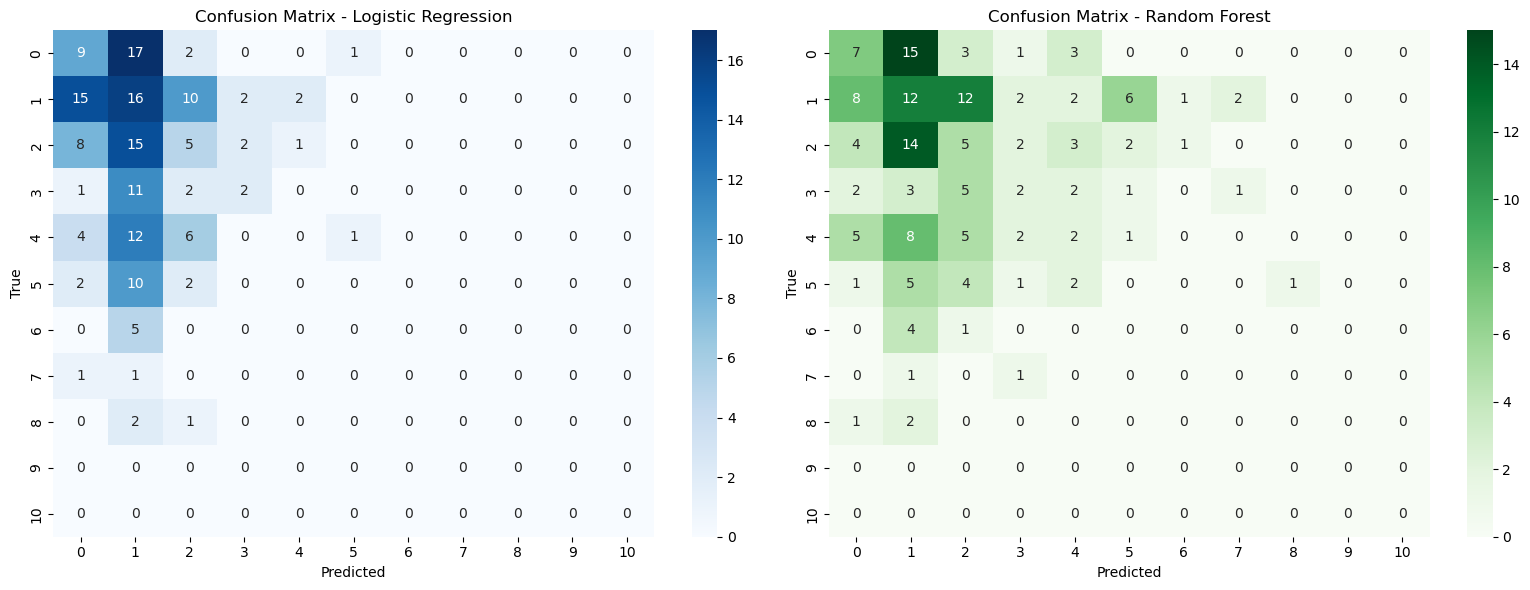

In [60]:
cm_lr = cm_lr.astype(int)
cm_rf = cm_rf.astype(int)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("Confusion Matrix - Logistic Regression")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("Confusion Matrix - Random Forest")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.show()